In [1]:
import numpy as np 
import os
import copy
from math import *
import matplotlib.pyplot as plt
from functools import reduce
# reading in dicom files
import pydicom
# skimage image processing packages
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops
# scipy linear algebra functions 
from scipy.linalg import norm
import scipy.ndimage
# ipywidgets for some interactive plots
from ipywidgets.widgets import * 
import ipywidgets as widgets
# plotly 3D interactive graphs 
import plotly
from plotly.graph_objs import *
import chart_studio.plotly as py
# set plotly credentials here 
# this allows you to send results to your account plotly.tools.set_credentials_file(username=your_username, api_key=your_key)

In [2]:
def load_scan(path):
    slices = [pydicom.dcmread(path + '/' + s) for s in               
              os.listdir(path)]
    slices = [s for s in slices if 'SliceLocation' in s]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

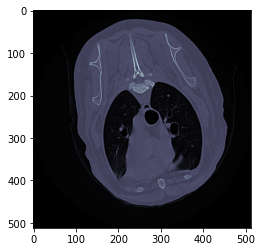

In [3]:
# set path and load files 
FOLDER_PATH = "E:/Egyetem/AI/_Orvosi képfeldolgozás/Datasets/positive_lung_CT/tudodaganat/"


path = FOLDER_PATH
patient_dicom = load_scan(path)
patient_pixels = get_pixels_hu(patient_dicom)
#sanity check
plt.imshow(patient_pixels[123], cmap=plt.cm.bone)

In [4]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)
    counts = counts[vals != bg]
    vals = vals[vals != bg]
    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
def segment_lung_mask(image, fill_lung_structures=True):
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image >= -700, dtype=np.int8)+1
    labels = measure.label(binary_image)
    background_label = labels[0,0,0]
 
    # Fill the air around the person
    binary_image[background_label == labels] = 2
 
    # Method of filling the lung structures (that is superior to 
    # something like morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
 
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
 
    # Remove other air pockets inside body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

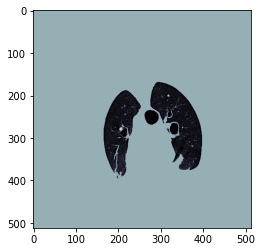

In [5]:
# get masks 
segmented_lungs = segment_lung_mask(patient_pixels,    
                  fill_lung_structures=False)
segmented_lungs_fill = segment_lung_mask(patient_pixels,     
                       fill_lung_structures=True)
internal_structures = segmented_lungs_fill - segmented_lungs
# isolate lung from chest
copied_pixels = copy.deepcopy(patient_pixels)
for i, mask in enumerate(segmented_lungs_fill): 
    get_high_vals = mask == 0
    copied_pixels[i][get_high_vals] = 0
seg_lung_pixels = copied_pixels
# sanity check
plt.imshow(seg_lung_pixels[123], cmap=plt.cm.bone)

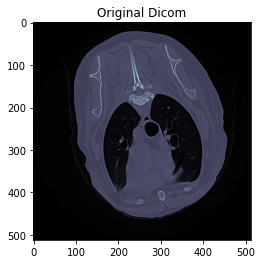

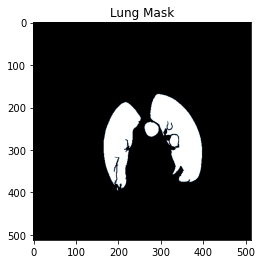

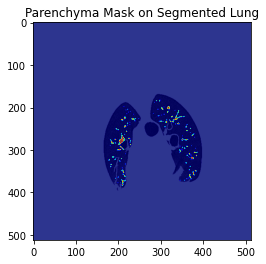

In [6]:
# pick random slice 
slice_id = 123
plt.figure(1)
plt.title('Original Dicom')
plt.imshow(patient_pixels[slice_id], cmap=plt.cm.bone)
plt.figure(2)
plt.title('Lung Mask')
plt.imshow(segmented_lungs_fill[slice_id], cmap=plt.cm.bone)
plt.figure(3)
plt.title('Parenchyma Mask on Segmented Lung')
plt.imshow(seg_lung_pixels[slice_id], cmap=plt.cm.bone)
plt.imshow(internal_structures[slice_id], cmap='jet', alpha=0.7)

In [7]:
print(len(patient_pixels))

308


In [9]:
from ipywidgets import interact

# slide through dicom images using a slide bar 
plt.figure(1)
#@interact(x=(0, 100))
def dicom_animation(x):
    plt.imshow(patient_pixels[x])
    return x
interact(dicom_animation, x=(0, len(patient_pixels)-1))

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=153, description='x', max=307), Output()), _dom_classes=('widget-interac…

<function __main__.dicom_animation(x)>

In [12]:
plt.figure(2)
#@interact(x=(0, 100))
def dicom_animation(x):
    plt.imshow(internal_structures[slice_id], cmap='jet', alpha=0.7)
    return x
interact(dicom_animation, x=(0, len(patient_pixels)-1))

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=153, description='x', max=307), Output()), _dom_classes=('widget-interac…

<function __main__.dicom_animation(x)>

In [11]:
plt.figure(1)
#@interact(x=(0, 100))
def dicom_animation(x):
    plt.imshow(seg_lung_pixels[slice_id], cmap=plt.cm.bone)
    return x
interact(dicom_animation, x=(0, len(patient_pixels)-1))

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=153, description='x', max=307), Output()), _dom_classes=('widget-interac…

<function __main__.dicom_animation(x)>